In [1]:
import numpy as np
import stumpy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from icecream import ic
from tqdm import tqdm
import arrow
from dateutil import tz
import joblib

timezone = tz.gettz("Asia/Tokyo")

In [33]:
def read_database(start=2016, stop=2024):
    db = {}
    for year in tqdm(np.arange(start, stop + 1, 1), desc="Reading database"):
        y = np.load(f"data/ntt_mss_{year}.npy")
        mids = np.load(f"data/ntt_mss_{year}_areas.npy")
        db[year] = (y, mids)
    return db

In [34]:
def join_database_of_meshcode(db, meshcode):
    for key in db.keys():
        meshids = db[key][1]
        try:
            pos = np.where(meshids == meshcode)[0].item()
        except:
            print(f"Meshcode {meshcode} not found in {key}")
            return None
        if key == 2016:
            data = db[key][0][:,pos]
        else:
            data = np.concatenate((data, db[key][0][:,pos]), axis=0)
    return data

In [35]:
def join_database_of_meshcode_with_nan(db, meshcode):
    for key in db.keys():
        meshids = db[key][1]
        try:
            pos = np.where(meshids == meshcode)[0].item()
        except:
            print(f"Meshcode {meshcode} not found in {key}")
            return None
        if key == 2016:
            data = db[key][0][:,pos]
        else:
            data = np.concatenate((data, db[key][0][:,pos]), axis=0)
    # change -1 to 0
    data = np.where(data == -1, 0, data)
    return data

In [36]:
def set_vars(cur):
    target_year = cur.year
    target_month = cur.month
    target_day = cur.day
    target_hour = cur.hour
    return target_year, target_month, target_day, target_hour

In [37]:
def get_date_one_month_ago(target_year, target_month, target_day, target_hour):
    to_date = arrow.get(target_year, target_month, target_day, target_hour).replace(tzinfo=timezone)
    last_month = to_date.shift(months=-1) #<= length of history data to start streaming
    return last_month.datetime

In [38]:
def end_of_year_bool(year1,year2):
    if year1 != year2:
        return True
    else:
        return False

In [39]:
def get_hours(start_year, start_month, start_day, start_hour, stop_year, stop_month, stop_day, stop_hour):
    start = datetime(start_year, start_month, start_day, start_hour, 0, 0, 0, tzinfo=timezone)
    stop = datetime(stop_year, stop_month, stop_day, stop_hour, 0, 0, 0, tzinfo=timezone)
    delta = stop - start
    return delta.days * 24 + delta.seconds // 3600


def get_dateindex(dt, num_days):
    index = sum(num_days[:dt.year-2016]) + get_hours(dt.year,1,1,0,dt.year,dt.month,dt.day,dt.hour)
    return index

def get_date_from_index(index, num_days):
    year = 2016
    while index >= num_days[year - 2016]:
        index -= num_days[year - 2016]
        year += 1
    month = 1
    while index >= get_hours(year, month, 1, 0, year, month + 1, 1, 0):
        index -= get_hours(year, month, 1, 0, year, month + 1, 1, 0)
        month += 1
    day = index // 24 + 1
    hour = index % 24
    return datetime(year, month, day, hour, tzinfo=timezone)


def get_history_data(data, num_days, cur, last_month, eoy_bool, alpha=0):
    if eoy_bool:
        alpha = 1
    for i, year in enumerate(np.arange(2016, last_month.year+1)):
        if cur.month == 2 and cur.day == 29 and year % 4 != 0: #<== added to handle Feb 29
            continue            
        start_index = get_dateindex(datetime(year,last_month.month,last_month.day,last_month.hour,0,0,0,timezone), num_days)
        stop_index = get_dateindex(datetime(year+alpha,cur.month,cur.day,cur.hour,0,0,0,timezone), num_days)
        if i == 0:    
            history_data = data[start_index:stop_index]
        else:
            history_data = np.concatenate((history_data, data[start_index:stop_index]), axis=0)
    return history_data[:-1]

In [40]:
def andes(data, num_days, cur, stream_point, meshcode):    
    target_year, target_month, target_day, target_hour = set_vars(cur)
    last_month = get_date_one_month_ago(target_year, target_month, target_day, target_hour)
    eoy_bool = end_of_year_bool(target_year, last_month.year)
    history_data = get_history_data(data, num_days, cur, last_month, eoy_bool)
    # convert data to float64 and replace -1 with np.nan
    history_data = np.where(history_data == -1, np.nan, history_data).astype(np.float64)
    stream_point = np.where(stream_point == -1, np.nan, stream_point).astype(np.float64)
    # calculate the left matrix profile
    T = history_data
    m = 3
    stream = stumpy.stumpi(T, m, normalize=False, egress=False)
    # update stream with new data
    stream.update(stream_point)
    # calculate the left MP
    mp = stream._left_P[m:]
    # filter initial 'inf' values
    mpf = mp[np.isfinite(mp)]
    # calculate std of the left MP ==> Condition for anomaly detection
    return T, mpf, stream._left_P[-1] > (mpf.mean() + 3 * mpf.std())

## Load Database

In [10]:
## Change this to Code Cell the first time you run the code 
### Runtime: 2min 30s
### Load the db dictionary from disk (use this in future sessions for rapid loading)
db = joblib.load('/Users/erick/Documents/GitHub/GPT_forecasting/db_2016_2024.joblib')

### YOU MAY RUN THIS ONCE TO LOAD THE DATABASE
db = read_database(start=2016, stop=2024)

# RUN FROM HERE

In [41]:
# INPUT CASES
# event_dt = datetime(2024,2,15,10,0,0,0,timezone) # Random non populated area
# meshcode = 574026822 #533937511 #DisneySea #574036064 #(Irides) #574026822 #(Moniwadai)
# event = 'Random Point'

# event_dt = datetime(2024,1,1,16,0,0,0,timezone) # Noto EQ @ Suzu
# meshcode = 563712214
# event = 'Noto EQ (Suzu)'

# event_dt = datetime(2018,7,7,1,0,0,0,timezone) # Kurashiki Flood
# meshcode = 513375542
# event = 'Kurashiki Flood'

event_dt = datetime(2022,3,16,23,0,0,0,timezone) # Fukushima EQ
meshcode = 574007523
meshcodes = [ 574007614, 574007623, 574007624, 574007633, 574007634,
            574007612, 574007621, 574007622, 574007631, 574007632,
            574007514, 574007523, 574007524, 574007533, 574007534,
            574007512, 574007521, 574007522, 574007531, 574007532,
            574007414, 574007423, 574007424, 574007433, 574007434,
            574007412, 574007421, 574007422, 574007431, 574007432,
            574007314, 574007323, 574007324, 574007333, 574007334 ]
meshcodes = [ 574007523, 574007524, 
            574007521, 574007522 ]
# original in tests: 574007523
event = 'Fukushima EQ'

# event_dt = datetime(2019,10,12,16,0,0,0,timezone) # Koriyama Flood
# meshcode = 564003523
# event = 'Koriyama Flood'

# event_dt = datetime(2024,7,8,0,0,0,0,timezone) # Wakayama Heavy Rain (Wakayama Sta., 513521831)
# meshcode = 513521831 
# event = 'Wakayama Heavy Rain'

# event_dt = datetime(2024,1,1,16,0,0,0,timezone) # Noto EQ @ Wajima
# meshcode = 563607723 #563607621 #563607721
# event = 'Noto EQ (Wajima)'



In [42]:
# THESE ARE NECESSARY BY MESHCODE (OFFLINE)
# get all years data together for the target meshcode
merge = False # if True, merge all meshcodes data into one np.array, if False, get only one meshcode data
if not merge:
    data = join_database_of_meshcode(db, meshcode)
    # ALWAYS NEEDED ===================================================================
    title = f"Meshcode: {meshcode}, Date: {event_dt.strftime('%Y-%m-%d %H:%M')}, {event}"
    filename = f"andes_{event.replace(' ','')}_{meshcode}_{event_dt.strftime('%Y%m%d%H%M')}"
else:
    #for each meschode from meshcodes list get the data, change -1 to np.nan and sum all np.arrays into one np.array
    data = np.sum([join_database_of_meshcode_with_nan(db, mc) for mc in meshcodes], axis=0)
    # ALWAYS NEEDED ===================================================================
    title = f"Merged, Date: {event_dt.strftime('%Y-%m-%d %H:%M')}, {event}"
    filename = f"andes_{event.replace(' ','')}_merged_{event_dt.strftime('%Y%m%d%H%M')}"
    data = np.where(data == -1, np.nan, data).astype(np.float64)
# create a list with shape of database for each year, number of hours per year
num_days = [db[key][0].shape[0] for key in db.keys()]

### Algorithm 1 - One Point data

In [43]:
# THIS IS SUPPOSED TO COME ONLINE - record at current time - here we take it from the database (ONLINE)
cur_index = get_dateindex(event_dt, num_days)
stream_point = data[cur_index]
andes(data, num_days, event_dt, stream_point, meshcode)

(array([173., 117., 150., ..., 142., 188., 243.]),
 array([ 91.87491497, 121.33836986,  56.36488268, ...,   6.78232998,
          6.40312424,   7.87400787]),
 np.False_)

### Algorithm 2 - Multiple point data

In [44]:
# TEST CASE FOR MULTIPLE DAYS
# create a list of dates for the last xhours
xhours = 14 * 24
dates_before = [event_dt - timedelta(hours=i) for i in range(xhours,0,-1)]
dates_after = [event_dt + timedelta(hours=i) for i in range(xhours)]
# dates = dates_before + dates_after # wrong?:dates start with dates already in T
dates = dates_after
img = []
for date in dates:
    # this is input data
    cur_index = get_dateindex(date, num_days)
    stream_point = data[cur_index]
    # online anomaly detection
    T, mpf, anomaly = andes(data, num_days, date, stream_point, meshcode)
    img.append(anomaly)
    if anomaly:
        ic(date)

ic| date: datetime.datetime(2022, 3, 17, 1, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Tokyo'))
ic| date: datetime.datetime(2022, 3, 17, 2, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Tokyo'))
ic| date: datetime.datetime(2022, 3, 26, 7, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Tokyo'))


In [45]:
arr = np.array(img).astype(int)
# add to arr cur.hours points of np.nan at the beginning
start_pad = np.full(dates[0].hour, np.nan)
arr = np.concatenate((start_pad, arr))
end_pad = np.full((23 - dates[-1].hour), np.nan)
arr = np.concatenate((arr,end_pad))
# add the current point to the array
# arr[len(start_pad)+len(dates_before)] = 2 # not good
arr[len(start_pad)] = 2

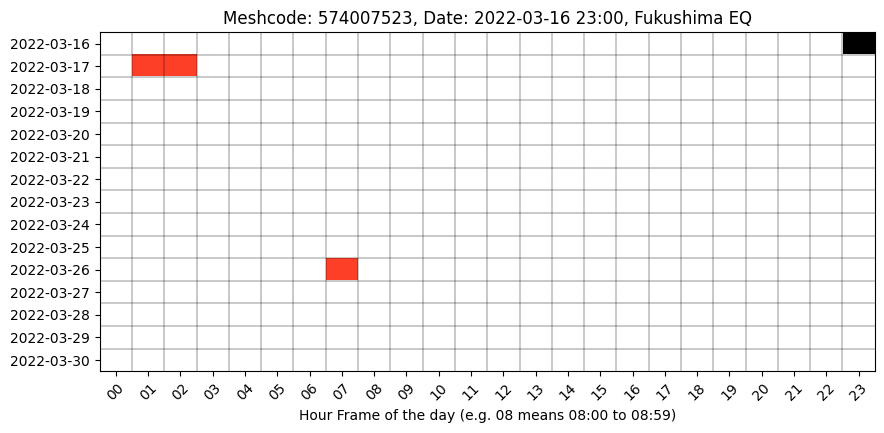

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(arr.reshape(-1,24), cmap='CMRmap_r', aspect=0.7)
days = set([dates[i].date() for i in range(len(dates))])
# set up y ticks labels
plt.yticks(np.arange(0,len(days)), [f"{i}" for i in sorted(days)])
plt.xticks(np.arange(0,24), [f"{i:02d}" for i in np.arange(0,24)], rotation=45);
# create vertical lines at 0.5 of each hour
for i in range(1,24):
    plt.axvline(i-0.5, color='black', linewidth=0.3)
# create horizontal lines at 0.5 of each hour
for i in range(1,len(days)):
    plt.hlines(i-0.5, xmin=-0.5,xmax=23.5,color='black', linewidth=0.3)
plt.xlabel("Hour Frame of the day (e.g. 08 means 08:00 to 08:59)")
plt.title(title)
plt.savefig(f"{filename}.png", dpi=300)

In [47]:
import plotly.graph_objs as go
import plotly.io as pio

fig = go.Figure()

# Plot the data (replace -1 with nan for better visualization)
plot_data = np.where(data == -1, np.nan, data)
fig.add_trace(go.Scatter(y=mpf, mode='lines', name='Data'))

# # Add vertical line for the current point
# fig.add_vline(
#     x=get_dateindex(event_dt, num_days),
#     line=dict(color='red', dash='dash'),
#     annotation_text='Current Point',
#     annotation_position='top right'
# )

fig.update_layout(
    title=title,
    xaxis_title='Index',
    yaxis_title='Value',
    hovermode='x unified'
)

fig.show()

In [140]:
mpf.shape[0]

5083

In [134]:
T.shape[0], (2*29+5*28)*24+14*24-1
mpf.shape[0]-(2*29+5*28)*24+3

334

In [148]:
5083-2*336

4411

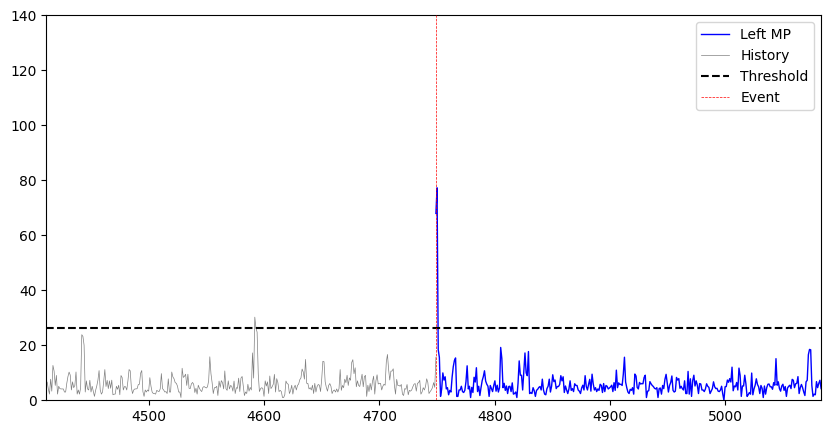

In [150]:
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(5083-334, 5083, 334), mpf[-334:], label='Left MP', color='blue', linewidth=1, zorder=1)
plt.plot(np.linspace(0, 5083-334, mpf.shape[0]-334), mpf[:-334], label='History', color='gray', linewidth=0.5)
plt.axhline(mpf.mean() + 3 * mpf.std(), color='black', linestyle='--', label='Threshold')
plt.axvline(x=5083-334, color='red', linestyle='--', label='Event', linewidth=0.5, zorder=5)
plt.ylim(0,140)
plt.xlim(4411,5083)
plt.legend()
plt.savefig(f"mpf.png", dpi=300)

In [18]:
import numpy as np

#Read the number of images from a folder, then load all images and create a (n/2)x(n/2) grid of images
def read_images_from_folder(folder):
    import os
    from PIL import Image
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            images.append(img)
    return images

def create_image_grid(images, grid_size):
    import numpy as np
    from PIL import Image

    # Create a blank image with white background
    grid_image = Image.new('RGB', (grid_size[0] * images[0].width, grid_size[1] * images[0].height), (255, 255, 255))

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            index = i * grid_size[1] + j
            if index < len(images):
                grid_image.paste(images[index], (i * images[0].width, j * images[0].height))

    return grid_image

def run():  
    # Load images from the folder
    images = read_images_from_folder('.')
    # images.sort(key=lambda x: int(x.filename.split('_')[2]))
    size = len(images)
    if size == 0:
        print("No images found in the folder.")
    elif size == 1:
        print("Only one image found, saving it directly.")
        images[0].save('single_image.png')
    elif size < 4:
        print(f"Only {size} images found, creating a grid of size {size}x{size}.")
        grid_size = (size, size)
        grid_image = create_image_grid(images, grid_size)
        # Save the grid image
        filename = 'FukushimaEQ'
        grid_image.save(f"{filename}_grid.png")
    elif size >= 4:
        rows = np.floor(np.sqrt(size))
        cols = np.floor(np.sqrt(size))
        if rows * cols < size:
            cols += 1
        grid_size = (int(rows), int(cols))
        print(f"Grid size: {grid_size[0]}x{grid_size[1]}")
        grid_image = create_image_grid(images, grid_size)
    # Save the grid image
    filename = 'FukushimaEQ'
    grid_image.save(f"{filename}_grid.png")
